In [230]:
import base64
from IPython.display import HTML
import json
import pandas as pd
import sys
import time
import datetime
from IPython.display import Markdown
import matplotlib.pyplot as plt

In [231]:
# to adapt report do:
# update `numOfBatches` to test-run batches count that we want to process
# update the `comparator['compareField']` logic

numOfBatches=2

In [232]:
def durationWithUnit(counter, timeOrCount, type):
    durationWithUnit=str(timeOrCount)
    if batches[counter]['Tests']['type']=='duration':
        return durationWithUnit+ ' sec'
    else:
        return durationSingleTest + ' requests'

In [233]:
def create_download_link( df, title = "Download CSV file", filename = "data.csv"):
    csv = df.to_csv()
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

In [234]:
def addCommonData(resultData):
    resultData['Deployment']=deployment
    resultData['Total CPUs']=totalCPUs
    resultData['Total Memory GB']=totalMemoryGB
    resultData['Duration Single Test']=durationSingleTest
    resultData['Persistence']=persistence
    resultData['App Process URL']=appProcessUrl

In [235]:
counter=1
batches=[]
while counter <= numOfBatches:
    batches.append(json.load(open('test-run'+str(counter)+'/batch.json')))
    #print(batches[counter-1])
    counter=counter+1

In [236]:
counter=0
sysDatas=[]
localHosts=['LOCAL','VM1','VM2']
while counter < numOfBatches:
    systemDataName='test-run'+str(counter+1)+'/results/system-data.csv'
    systemData = pd.read_csv(systemDataName, names=['javaversion', 'totalCPUs', 'totalMemoryGB'],header=0, index_col=False)
    sysData={}
    sysData['comments']=batches[counter]['Comments']
    sysData['jdkVersion']=systemData.javaversion[0]
    sysData['totalCPUs']=systemData.totalCPUs[0]
    sysData['totalMemoryGB']=systemData.totalMemoryGB[0]
    sysData['appVersion']=batches[counter]['InfraSetup']['appVersion']
    sysData['tester']=batches[counter]['InfraSetup']['tester']
    sysData['app']=batches[counter]['InfraSetup']['app']
    sysData['testEngine']=batches[counter]['InfraSetup']['testClient']
    sysData['deployment']='On-premise' if (sysData['tester']['name'] in localHosts and sysData['app']['name'] in localHosts) else 'Cloud'
    appProcess=batches[counter]['Process']
    appProcessUrl=appProcess['schema']+"://"+appProcess['url']+':'+str(appProcess['port'])+'/'+appProcess['app']
    sysData['appProcessUrl']=appProcessUrl
    appInfra=batches[counter]['AppInfra']
    persistence='Mongo' if appInfra['Mongo']=='yes' else 'PostgresQL' if appInfra['PostgresQL']=='yes' else 'None'
    sysData['persistence']=persistence

    sysDatas.append(sysData)
    counter=counter+1
    #print(sysData)


In [237]:
counter=0
testConfigs=[]
while counter < numOfBatches:
    testConfig={}
    testConfig['durationSingleTest']=durationWithUnit(counter, batches[counter]['Tests']['timeOrCount'], batches[counter]['Tests']['type'])
    testConfig['warmup']='no' if batches[counter]['Warmup']=="no" else durationWithUnit(counter, batches[counter]['Warmup']['timeOrCount'], batches[counter]['Warmup']['type'])
    testConfig['properties']=batches[counter]['ProcessProperties']

    testConfigs.append(testConfig)
    counter=counter+1
    # print(testConfig)


In [238]:
# the data which will be the data we compare the runs against
counter=0
comparators=[]
while counter < numOfBatches:
    comparator={}
    # comparator['compareField']=sysDatas[counter]['persistence']+'-'+sysDatas[counter]['appVersion']
    comparator['compareField']=batches[counter]['ProcessProperties'][0]['val']  # workers num

    comparators.append(comparator)
    counter=counter+1
    # print(comparator)

In [239]:
counter=0
testRun=0
testResults=[]
minTimestamp=sys.maxsize
maxTimestamp=0
while counter < numOfBatches:
    testRun=0
    for test in batches[counter]['Tests']['runs']:
        csvName='test-run'+str(counter+1)+'/results/res'+str(testRun)+'.csv'
        result = pd.read_csv(csvName, header=0, index_col=False)
        # print(result)
        resultData={}
        resultData['persistence']=sysDatas[counter]['persistence']
        resultData['appVersion']=sysDatas[counter]['appVersion']
    
        resultData['#Replicas']=test['replicas']
        resultData['#Users']=test['users']
        resultData['MRT(ms)']=result.Average[0]
        resultData['RPS']=result.Throughput[0]
        # print(resultData)

        usageName='test-run'+str(counter+1)+'/results/usage'+str(testRun)+'.csv'
        usage = pd.read_csv(usageName, 
            names=['appCpuUsage', 'systemCpuUsage', 'appMemoryUsage', 'appMemoryUsagePercentage', 'systemMemoryUsage', 'systemMemoryUsagePercentage'],
            header=0, index_col=False)
        resultData['CPU Usage-app']=usage.appCpuUsage[0]
        resultData['CPU Usage-system']=usage.systemCpuUsage[0]
        resultData['Memory Usage-app']=usage.appMemoryUsage[0]
        resultData['Memory Usage%-app']=usage.appMemoryUsagePercentage[0]
        resultData['Memory Usage-system']=usage.systemMemoryUsage[0]
        resultData['Memory Usage%-system']=usage.systemMemoryUsagePercentage[0]
        # print(resultData)

        # here add column or column combination to use as aggregator e.g. persistence+appversion or a property
        resultData['compareField']=comparators[counter]['compareField']


        testResults.append(resultData)

        jtlName='test-run'+str(counter+1)+'/results/res'+str(testRun)+'.jtl'
        jtl = pd.read_csv(jtlName, header=0, index_col=False)
        minTimestamp=min([minTimestamp, jtl.timeStamp[0]])
        maxTimestamp=max([maxTimestamp, jtl.timeStamp[len(jtl)-1]])

        testRun=testRun+1
    counter=counter+1

# print(testResults)

In [240]:
startTime=time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(minTimestamp/1000))
endTime=time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(maxTimestamp/1000))
batchDuration=str(datetime.timedelta(seconds=(maxTimestamp/1000-minTimestamp/1000)))

# counter=0
# aggData='* Persistence | Kogito version combinations:'
# while counter < numOfBatches:
#     aggData+='\n - '+sysDatas[counter]['persistence'] + ' | ' + sysDatas[counter]['appVersion']
#     counter=counter+1


counter=0
aggData='* Workers/Pool limits:'
while counter < numOfBatches:
    aggData+='\n    - Series '+str(counter+1)+' Limit:'+str(comparators[counter]['compareField'])
    counter=counter+1
# print(aggData)    

In [241]:
Markdown("""
# Kogito Benchmark Multiple Batch Runs
## Test Environment
* Deployment:  {deployment}
* Duration of each test: {durationSingleTest}
* Warmup: {warmup}
* Process: {appProcessUrl}
{aggDataOut}

""".format(deployment=sysDatas[0]['deployment'],aggDataOut=aggData,
durationSingleTest=testConfigs[0]['durationSingleTest'],warmup=testConfigs[0]['warmup'],appProcessUrl=sysDatas[0]['appProcessUrl']))




# Kogito Benchmark Multiple Batch Runs
## Test Environment
* Deployment:  On-premise
* Duration of each test: 120 sec
* Warmup: 60 sec
* Process: http://appeng-vm02.cloud.lab.eng.bos.redhat.com:8080/simpleHT
* Workers/Pool limits:
    - Series 1 Limit:10
    - Series 2 Limit:100



In [242]:
Markdown("""
## Test Client
* Client host: {hostname}
* Test engine:  {testEngine}
""".format(hostname=sysDatas[0]['tester']['hostname'],testEngine=sysDatas[0]['testEngine']))



## Test Client
* Client host: appeng-vm01.cloud.lab.eng.bos.redhat.com
* Test engine:  JMETER


In [243]:
Markdown("""
## Test Service
* Service host: {hostname} ({totalCPUs} CPU cores, {totalMemoryGB} GB Memory)
* JDK version:  {jdkVersion}
{aggDataOut}
""".format(hostname=sysDatas[0]['app']['hostname'],totalCPUs=sysDatas[0]['totalCPUs'],totalMemoryGB=sysDatas[0]['totalMemoryGB'],
jdkVersion=sysDatas[0]['jdkVersion'],aggDataOut=aggData))



## Test Service
* Service host: appeng-vm02.cloud.lab.eng.bos.redhat.com (4 CPU cores, 15.51 GB Memory)
* JDK version:  openjdk version "11.0.12" 2021-07-20 LTS
* Workers/Pool limits:
    - Series 1 Limit:10
    - Series 2 Limit:100


## Execution Report
### Chart view

In [244]:
raw = pd.DataFrame(testResults)
# print(raw)

In [245]:
# raw.insert(1,'Start Time', startTime)
# raw.insert(2,'End Time', endTime)
# raw.insert(3,'Batch Duration', batchDuration)


In [246]:
users = raw['#Users'].unique()
# print(users)

In [247]:
counter=0
combinedData = {}
for r in raw['compareField'].unique():
    colValues = raw[raw['compareField']==r]['MRT(ms)'].values
    combinedData[r] = colValues    

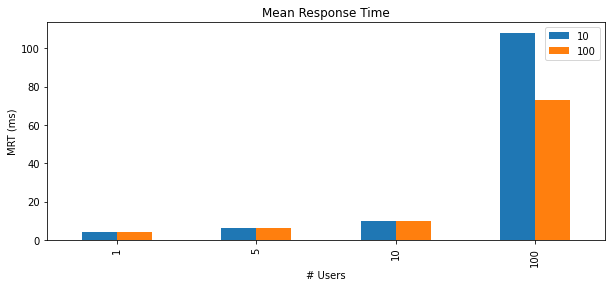

In [248]:
mrtDF = pd.DataFrame(combinedData, index=users)
mrtDF.plot(kind="bar")
plt.title("Mean Response Time")
plt.xlabel("# Users")
plt.ylabel("MRT (ms)")
plt.rcParams["figure.figsize"] = (10,4)


In [249]:
counter=0
combinedData = {}
for r in raw['compareField'].unique():
    colValues = raw[raw['compareField']==r]['RPS'].values
    combinedData[r] = colValues    

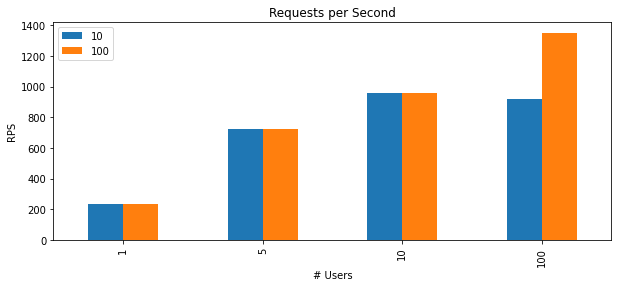

In [250]:
mrtDF = pd.DataFrame(combinedData, index=users)

mrtDF.plot(kind="bar")
plt.title("Requests per Second")
plt.xlabel("# Users")
plt.ylabel("RPS")
plt.rcParams["figure.figsize"] = (10,4)

In [251]:
counter=0
combinedData = {}
for r in raw['compareField'].unique():
    colValues = raw[raw['compareField']==r]['CPU Usage-app'].str.replace('%','').apply(pd.to_numeric).values
    combinedData[r] = colValues      

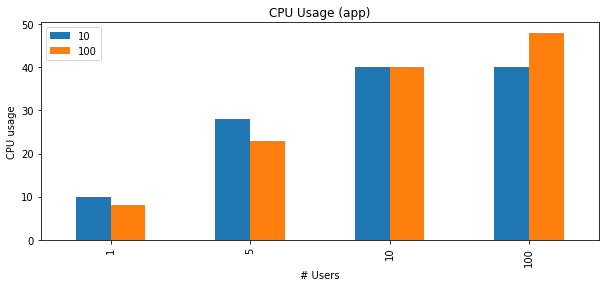

In [252]:
cpusDF = pd.DataFrame(combinedData, index=users)
cpusDF.plot(kind="bar")
plt.title("CPU Usage (app)")
plt.xlabel("# Users")
plt.ylabel("CPU usage")
plt.rcParams["figure.figsize"] = (10,4)

In [253]:
counter=0
combinedData = {}
for r in raw['compareField'].unique():
    colValues = raw[raw['compareField']==r]['Memory Usage-app'].str.replace('MB','').apply(pd.to_numeric).values
    combinedData[r] = colValues  

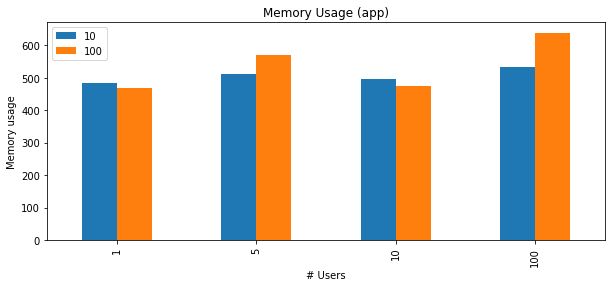

In [254]:
memoryUsageDF = pd.DataFrame(combinedData, index=users)
memoryUsageDF.plot(kind="bar")
plt.title("Memory Usage (app)")
plt.xlabel("# Users")
plt.ylabel("Memory usage")
plt.rcParams["figure.figsize"] = (10,4)

### Tabular view

In [255]:
raw.style.hide_index().hide_columns(['compareField'])

persistence,appVersion,#Replicas,#Users,MRT(ms),RPS,CPU Usage-app,CPU Usage-system,Memory Usage-app,Memory Usage%-app,Memory Usage-system,Memory Usage%-system
Mongo,CoreFix-mem-idx-2.0.0-snap,1,1,4,232.000000,10%,23.50%,484.61MB,3.05%,1362.14MB,8.57%
Mongo,CoreFix-mem-idx-2.0.0-snap,1,5,6,723.800000,28%,63.70%,511.27MB,3.21%,1447.92MB,9.11%
Mongo,CoreFix-mem-idx-2.0.0-snap,1,10,10,959.200000,40%,72.20%,497.21MB,3.13%,1432.59MB,9.01%
Mongo,CoreFix-mem-idx-2.0.0-snap,1,100,108,918.100000,40%,78.60%,532.23MB,3.35%,1484.33MB,9.34%
Mongo,CoreFix-mem-idx-2.0.0-snap,1,1,4,233.900000,8%,23.40%,470.17MB,2.96%,1363.77MB,8.58%
Mongo,CoreFix-mem-idx-2.0.0-snap,1,5,6,721.600000,23%,59.60%,569.10MB,3.58%,1495.86MB,9.41%
Mongo,CoreFix-mem-idx-2.0.0-snap,1,10,10,957.200000,40%,76.80%,474.17MB,2.98%,1425.64MB,8.97%
Mongo,CoreFix-mem-idx-2.0.0-snap,1,100,73,1350.400000,48%,95.70%,638.92MB,4.02%,1824.14MB,11.48%


In [256]:
# downloadName=(deployment+'_'+startTime+'.csv').replace(':',"_").replace(' ',"_")
# create_download_link(df=raw, filename=downloadName, title='Download detailed CSV report')